**Learning Note 學習筆記 - TensorFlow - Regression**<p>
Using TensorFlow to bruild a Neural Network for Regression and predict the chance of a student being admitted from a school.</br>
使用TensorFlow打造一個類神經網路，並預測學生被學校錄取的機率。</br>

In [3]:
import pandas as pd
from scipy.stats import randint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor

#Load data and take a look
admdata = pd.read_csv('admissions_data.csv')
print(admdata.head())
print(admdata.describe())

#We don't need the serial no.
admdate = admdata.drop(['Serial No.'], axis=1)

   Serial No.  GRE Score  TOEFL Score  University Rating  SOP  LOR   CGPA  \
0           1        337          118                  4  4.5   4.5  9.65   
1           2        324          107                  4  4.0   4.5  8.87   
2           3        316          104                  3  3.0   3.5  8.00   
3           4        322          110                  3  3.5   2.5  8.67   
4           5        314          103                  2  2.0   3.0  8.21   

   Research  Chance of Admit   
0         1              0.92  
1         1              0.76  
2         1              0.72  
3         1              0.80  
4         0              0.65  
       Serial No.   GRE Score  TOEFL Score  University Rating         SOP  \
count  500.000000  500.000000   500.000000         500.000000  500.000000   
mean   250.500000  316.472000   107.192000           3.114000    3.374000   
std    144.481833   11.295148     6.081868           1.143512    0.991004   
min      1.000000  290.000000    92.0

**Data Processing 資料處理**<p>
- We are going to train the model predicting posibility of an application being admitted, therefore, "Chance of Admit" will be our label.</br>
- We then split the data as training set and test set.</br>
- Since neural network cannot work with string data, we may need to use One-hot Encode to transform data if needed.</br>
- Numerical data usually have different scales, we need to scale it so that every feature has same weight. Standardization and Normalization are two ways to do this.<p>
- 我們要預測被錄取的機率，因此"Chance of Admit"是我們的label。</br>
- 接下來將資料拆分為training和test兩組。</br>
- 因為類神經網路無法處理文字資料，因此如果有文字類型的feature，可用One-hot Encode的方式轉換成數字。</br>
- 數字資料通常會有不同的範圍，這會造成訓練時各feature比重不同，因此需要將features轉換為相同的範圍，常見的方式是標準化(Standardization)和正規化(Normalization)。

In [5]:
#Split features and labels, as well as train and test
features = admdata.iloc[:, :-1]
labels = admdata.iloc[:, -1]
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=46)

#Standardize
numerical_features = features.select_dtypes(include=['float64', 'int64'])
numerical_columns = numerical_features.columns
ct = ColumnTransformer([('only_numeric', StandardScaler(), numerical_columns)], remainder='passthrough')
features_train_scaled = ct.fit_transform(features_train)
features_test_scaled = ct.fit_transform(features_test)

**Create Neural Network Model 打造類神經網路模組**<p>
- Sequential model is a popular model to build neural network. Layers by layers.</br>
- TensorFlow determine the shapes of weight metrix and bias metrix automatically.</br>
- InputLayer needs to have the number of features as it's first dimension.</br>
- Hidden layers are the key of neural network, there may be multiple layers depend on the model design. We will have the number of neurons and activation function we are going to use. Relu is an effective and popular function. For graphic purpose, we may need softmax and sigmoid.</br>
- Dropout layers will randomly ignore some output to and set them as zero to prevent overfitting. It will make the learning more regular and simpler, the learning curve will be more smooth. Usually we set it between 20%-50%.</br>
- Output layer shape depend on how many features we are looking for as labels, here we are only looking for one, chance of admit.</br>
- Just like machine learning, we need an optimizer and determine how far it should jump, which is learning rate.</br>
- Loss funtion let us know how well/poor our model is by looking into Mean Squared Error. We also want to know the Mean Absolute Error.<p>
- Sequential是常見的類神經網路模組。</br>
- TensorFlow會依輸入的資料，自動判斷權重矩陣與偏差矩陣的維度。</br>
- 輸入層(InputLayer)的起始維度必須是資料的features數量。</br>
- 隱藏層(Hidden Layers)是類神經網路的核心，取決於模組設計可能會有許多層。隱藏層需要提供類神經數量及激勵函數(Activation function)，Relu是常見且有效率的激勵函數，若為圖像判斷可能會使用Softmax或Sigmoid。</br>
- 丟棄層(Dropout Layers)會隨機放棄一些epochs，並將這些epochs的輸出設定為0，用來防止可能的overfitting。丟棄層可以使模組學習更簡單和常規，學習曲線也會更平滑。通常會設定在20%-50%之間。</br>
- 輸出層的維度取決於label，這裡我們只有"Chance of admit"一個。</br>
- 指派一個優化器(Optimizer)及學習率(Learning Rate)進行編譯。</br>
- 並在損失函數(Loss Function)使用均方誤差(Mean Squared Error)及平均絕對誤差(Mean Absolute Error)讓我們了解我們打造的模組的表現好壞。</br>

In [7]:
# Create neural network model
def neural_model():
    model = Sequential()
    input = InputLayer(shape=(features.shape[1], ))
    model.add(input)
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    print(model.summary())
    
    #Initialize optimizer and complie the model
    opt = Adam(learning_rate=0.01)
    model.compile(loss='mse', metrics=['mae'], optimizer=opt)
    return model
    

**Fit and evaluate the model 訓練並評估模組**<p>
- Early Stopping, preventing overfitting if the number of epochs is large.</br>
    - We monitor the model by its 'val_loss'.</br>
    - We are looking for minimal loss.</br>
    - patience parameter tells the model how many more epochs we monitor if the model reachs plateau.</br>
- Fit model parameters</br>
    - features and labels of training dataset</br>
    - epochs, the number of cycles through the full training dataset. A hyperparameter.</br>
    - batch_size, the number of data points to work through before updating the model parameters. A hyperparameter.</br>
    - verbose, set it as 1 will show the progress bar.</br>
    - validation_split, what size of data will be used to validate the model.</br>
    - callbacks, we apply the Early Stopping function.</br>
- Evaluation, we may check Mean Squared Error and Mean Absolute Error, as well as score function to determine how the model perform.<p>
- 如果有很大的epochs時，提前停止(Early Stopping)可用來防止overfitting。</br>
    - 使用'val_loss'來監測模組。</br>
    - 尋找最小的損失。</br>
    - pateience參數告訴模組，當模組學習曲線達到平坦位置後，要再多監測多少epochs再停止。</br>
- 模組參數</br>
    - 資料的features和labels。</br>
    - epochs，當所有資料都被訓練過一次就是一個epoch，這個參數告訴模組要使用整個訓練資料進行多少次訓練。是一個超參數。</br>
    - batch_size，一次訓練所使用的資料數量。是一個超參數。</br>
    - verbose，當設定為1時會顯示進度條。</br>
    - validation_split，要拆分並保留多少資料已用來驗證。</br>
    - callbacks, 使用方才設定的提前停止涵式。</br>
- 評估，使用均方誤差(Mean Squared Error)和平均絕對誤差(Mean Absolute Error)，以及決定係數(r2_score)涵式來評估訓練的模組好壞。</br>

In [9]:
#Fit and evaluate the model
def fit_model(f_tr, f_ts, l_tr, l_ts, epochs, batch_size):
    model = neural_model()
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
    history = model.fit(f_tr, l_tr, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.3, callbacks=[es])
    acp_mse, acp_mae = model.evaluate(f_ts, l_ts, verbose=0)
    print('MAE: ', acp_mae)
    print('MSE: ', acp_mse)
    y_pred = model.predict(f_ts)
    print(r2_score(l_ts, y_pred))
    return history

history = fit_model(features_train_scaled, features_test_scaled, labels_train, labels_test, 100, 10)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2984 - mae: 0.4323 - val_loss: 0.0293 - val_mae: 0.1396
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0700 - mae: 0.2055 - val_loss: 0.0181 - val_mae: 0.1121
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0283 - mae: 0.1346 - val_loss: 0.0124 - val_mae: 0.0971
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0174 - mae: 0.1065 - val_loss: 0.0067 - val_mae: 0.0637
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0146 - mae: 0.0946 - val_loss: 0.0094 - val_mae: 0.0840
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - mae: 0.1050 - val_loss: 0.0075 - val_mae: 0.0729
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0146 - mae: 0.0951 - val_loss: 0.0052 - val_mae: 0.0541
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0088 - mae: 0.0726 - val_loss: 0.0066 - val_mae: 0.0702
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 

**Plotting 繪圖**<p>
Plotting the MAE and MSE of the model.</br>
繪製模組訓練的MAE和MSE曲線。batch_size。</br>

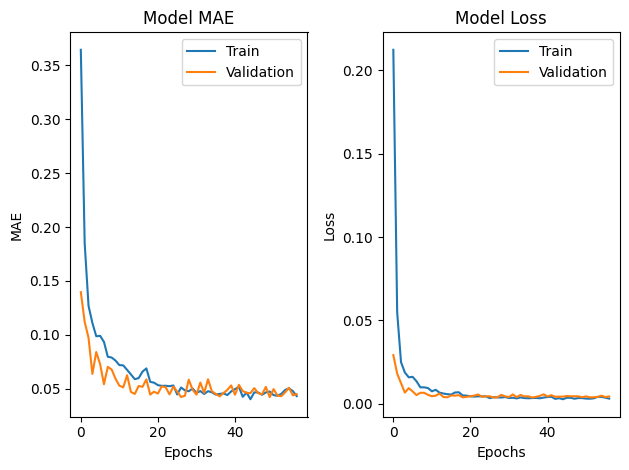

In [11]:
#Plotting
def plotting(history):
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.plot(history.history['mae'])
    ax1.plot(history.history['val_mae'])
    ax1.set_title('Model MAE')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('MAE')
    ax1.legend(['Train', 'Validation'], loc='upper right')
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['Train', 'Validation'], loc='upper right')
    
    fig.tight_layout()
    plt.show()

plotting(history)

**Tunning Hyperparameters 超參數調教**<p>
- Batch size, epochs, number of layers, as well as learning rate are common parameters for tuning.</br>
- Using best_score_ and best_params_ to get the best combination and accuracy.<p>
- Epochs, batch size, 隱藏層數, 學習率等都是可以進行調教的超參數。</br>
- 調教後使用best_score_和best_params_涵式提取最佳係數及參數組合。</br>

In [13]:
#Tunning parameters
def params_tunning():
    params = {'batch_size': randint(4, 64), 'epochs': randint(10, 100)}
    model = KerasRegressor(model=neural_model)
    tunning = RandomizedSearchCV(estimator=model, param_distributions=params, scoring=make_scorer(mean_squared_error, greater_is_better=False), return_train_score=True)
    tunning_results = tunning.fit(features_train_scaled, labels_train, verbose=0)
    print(tunning_results)
    print('Best score: %f using params: %r'% (tunning_results.best_score_, tunning_results.best_params_))
    return tunning_results.best_params_
    
tunning_params = params_tunning()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_34 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_36 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_40 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_42 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_44 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_46 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_48 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_50 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_54 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_56 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_58 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_60 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_62 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_64 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_66 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_68 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_72 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_74 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_76 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_78 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_80 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_82 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_86 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_88 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


Model: "sequential_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_92 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Model: "sequential_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_94 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_95 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


Model: "sequential_48"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_96 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Model: "sequential_49"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_98 (Dense)                │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_100 (Dense)               │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


C:\Users\Fenrir\anaconda3\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Model: "sequential_51"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_102 (Dense)               │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
RandomizedSearchCV(estimator=KerasRegressor(model=<function neural_model at 0x00000232FF008360>),
                   param_distributions={'batch_size': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000232FF0F4C50>,
                                        'epochs': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000232FF044690>},
                   return_train_score=True,
                   scoring=make_scorer(mean_squared_error, greater_is_better=False, response_method='predict'))
Best score: -0.004190 using params: {'batch_size': 37, 'epochs': 80}


**Use the best parameter 使用最佳參數**<p>
After Tuning and get the best combination of parameters, we then apply these parameters to our model.</br>
調教後套用最佳參數在我們的類神經網路模組。</br>

In [15]:
best_params = fit_model(features_train_scaled, features_test_scaled, labels_train, labels_test, tunning_params['epochs'], tunning_params['batch_size'])


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_104 (Dense)               │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641 (2.50 KB)

 Trainable params: 641 (2.50 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.6355 - mae: 0.6451 - val_loss: 0.2660 - val_mae: 0.3838
Epoch 2/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1946 - mae: 0.3304 - val_loss: 0.0224 - val_mae: 0.1257
Epoch 3/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0888 - mae: 0.2480 - val_loss: 0.0972 - val_mae: 0.2576
Epoch 4/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0969 - mae: 0.2505 - val_loss: 0.0281 - val_mae: 0.1395
Epoch 5/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0597 - mae: 0.1888 - val_loss: 0.0220 - val_mae: 0.1190
Epoch 6/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0504 - mae: 0.1723 - val_loss: 0.0100 - val_mae: 0.0787
Epoch 7/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0359 - mae: 0.1506 - val_loss: 0.0164 - val_mae: 0.1097
Epoch 8/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0319 - mae: 0.1424 - val_loss: 0.0091 - val_mae: 0.0769
Epoch 9/80
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0223 - mae: 0.11

**Plotting with the best parameters 最佳參數模組繪圖**<p>

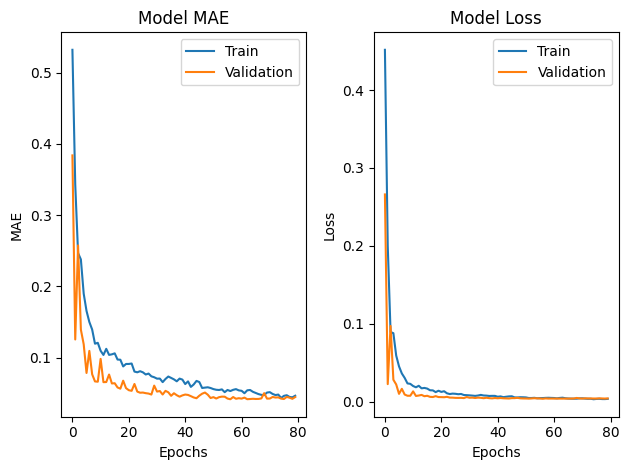

In [17]:
plotting(best_params)